In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
rng = np.random.default_rng()

In [2]:
current_working_directory = os.getcwd()
path = os.path.dirname(current_working_directory)
year = "2019"
result_path = f"{path}/CW/data/Results/"

In [3]:
def impact_resultant_prices(model, trades, prices, decay_factor, estimated_lambda, sigma, ADV, back=False):
    trades_copy = trades.copy()
    if back:
        trades_copy *= -1

    if model == "OW":
        trades_copy = trades_copy
    elif model == "Bouchaud":
        trades_copy = np.sign(trades_copy) * np.sqrt(np.abs(trades_copy))
    elif model == "Reduced":
        trades_copy = np.abs(trades_copy)
    else:
        raise ValueError("Unsupported model")

    # Adjust trades for decay
    trades_copy[1:] /= (1 - decay_factor)

    # Scale trades by price volatility and ADV
    if model == "OW":
        trades_copy *= sigma * estimated_lambda/ ADV
    elif model == "Bouchaud":
        trades_copy *= sigma * estimated_lambda/ np.sqrt(ADV)
    elif model == "Reduced":
        v_t = trades_copy.ewm(alpha=1 - decay_factor, adjust=False).mean()
        trades_copy *= sigma * estimated_lambda/ np.sqrt(ADV * v_t + 1e-10)  # use 1e-10 to avoid division by zero

    Impact = trades_copy.ewm(alpha=1-decay_factor, adjust=False).mean()

    Returns = prices / prices.iloc[0] - 1
    Returns += Impact
    # Return resultant prices
    return prices.iloc[0] * (Returns + 1)

In [4]:
def compute_regression_result(daily_stock_reg_info_df, in_sample_month):
    daily_stock_reg_info_df['date'] = pd.to_datetime(daily_stock_reg_info_df['date'])
    in_sample_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["date"].dt.month == in_sample_month]
    out_sample_df = daily_stock_reg_info_df.loc[daily_stock_reg_info_df["date"].dt.month == in_sample_month + 1]

    # for each stock, calculate the sum of x, y, xy, x^2, y^2, and count
    in_sample_result_df = in_sample_df.groupby("stock")[["xy", "x2", "y2", "x", "y", "count"]].sum()
    out_sample_result_df = out_sample_df.groupby("stock")[["xy", "x2", "y2", "x", "y", "count"]].sum()

    in_sample_result_df.columns = "IS_" + in_sample_result_df.columns
    out_sample_result_df.columns = "OOS_" + out_sample_result_df.columns

    result_df = pd.merge(in_sample_result_df, out_sample_result_df, left_index=True, right_index=True, how="inner")

    Cov_x_y = result_df["IS_xy"] - result_df["IS_x"] * result_df["IS_y"] / result_df["IS_count"]
    Var_x = result_df["IS_x2"] - result_df["IS_x"] ** 2 / result_df["IS_count"]
    result_df["lambda_estimate"] = Cov_x_y / Var_x
    result_df["epsilon_estimate"] = result_df["IS_y"] / result_df["IS_count"] - result_df["lambda_estimate"] * result_df["IS_x"] / result_df["IS_count"]
    result_df["IS_SST"] = result_df["IS_y2"] - result_df["IS_y"] ** 2 / result_df["IS_count"]
    result_df["IS_RSS"] = (result_df["IS_count"] * result_df["epsilon_estimate"] ** 2 +
                           2 * result_df["epsilon_estimate"] * result_df["lambda_estimate"] * result_df["IS_x"] -
                           2 * result_df["epsilon_estimate"] * result_df["IS_y"] +
                           result_df["lambda_estimate"] ** 2 * result_df["IS_x2"] -
                           2 * result_df["lambda_estimate"] * result_df["IS_xy"] +
                           result_df["IS_y2"])
    result_df["IS_R2"] = 1 - result_df["IS_RSS"] / result_df["IS_SST"]

    result_df["OOS_SST"] = result_df["OOS_y2"] - result_df["OOS_y"] ** 2 / result_df["OOS_count"]
    result_df["OOS_RSS"] = (result_df["OOS_count"] * result_df["epsilon_estimate"] ** 2 +
                            2 * result_df["epsilon_estimate"] * result_df["lambda_estimate"] * result_df["OOS_x"] -
                            2 * result_df["epsilon_estimate"] * result_df["OOS_y"] +
                            result_df["lambda_estimate"] ** 2 * result_df["OOS_x2"] -
                            2 * result_df["lambda_estimate"] * result_df["OOS_xy"] +
                            result_df["OOS_y2"])
    result_df["OOS_R2"] = 1 - result_df["OOS_RSS"] / result_df["OOS_SST"]

    return result_df

In [7]:
num_days_precompute = 20
filename = f"inter_results_stock_info_df_{year}all.csv"
stock_info_df = pd.read_csv(result_path+filename)
stacked_info = stock_info_df.pivot(index="date", columns="stock", values=["px_vol", "volume"]).rolling(num_days_precompute).mean().shift(1)
scaling_df = pd.DataFrame({
    "px_vol": stacked_info["px_vol"].unstack(),
    "volume": stacked_info["volume"].unstack(),
}).reset_index()

asset = "AAPL"
dates = "2019-03-14"

ssdf = scaling_df[(scaling_df["stock"] == asset) & (scaling_df["date"] == dates)]
price_vol = ssdf["px_vol"]
ADV = ssdf["volume"]
decay = np.exp(-np.log(2) / 3600 * 10)

month = dates.split("-")[1]
in_sample = int(month) - 1

filename = f"inter_results_px_df_{2019}{month}.csv"
px_df = pd.read_csv(result_path+filename).set_index(["stock","date"])
filename = f"inter_results_trade_volume_df_{2019}{month}.csv"
volumes = pd.read_csv(result_path+filename).set_index(["stock","date"])
prices = px_df.loc[(asset,dates)]
trades = volumes.loc[(asset,dates)]

In [8]:
filename = f"OW_reg_info_{year}_horizon{1}_beta{60}mins.csv"
test_OW = pd.read_csv(result_path+filename)
res_ow = compute_regression_result(test_OW, in_sample)
res_ow = res_ow.loc[asset]

In [9]:
def synthetic_alpha_generator(rho: float, prices: pd.DataFrame, horizon: int):
    """
    rho: correlation
    horizon: number of 10 seconds
    prices: impact-adjusted prices
    """
    x = rho ** 2
    returns = prices.pct_change(horizon)
    var = returns.var()
    p_minus2 = 1/(prices**2)
    p_minus_mean = p_minus2.mean()
    h = horizon
    y = rho * np.sqrt(1-rho**2)*np.sqrt(var/(h*p_minus_mean))
    normal = rng.normal(loc = 0, scale = h, size = prices.shape)
    res = x * returns + y * normal / prices
    
    return res.fillna(0),returns

In [30]:
def synthetic_alpha(rho, asset, dates):
    """
    rho: correlation
    asset: name of stock
    dates: date of trade
    """
    ssdf = scaling_df[(scaling_df["stock"] == asset) & (scaling_df["date"] == dates)]
    price_vol = ssdf["px_vol"]
    ADV = ssdf["volume"]
    decay = np.exp(-np.log(2) / 3600 * 10)

    month = dates.split("-")[1]
    in_sample = int(month) - 1

    filename = f"inter_results_px_df_{2019}{month}.csv"
    px_df = pd.read_csv(result_path+filename).set_index(["stock","date"])
    filename = f"inter_results_trade_volume_df_{2019}{month}.csv"
    volumes = pd.read_csv(result_path+filename).set_index(["stock","date"])
    prices = px_df.loc[(asset,dates)]
    trades = volumes.loc[(asset,dates)]
    filename = f"OW_reg_info_{year}_horizon{1}_beta{60}mins.csv"
    test_OW = pd.read_csv(result_path+filename)
    res_ow = compute_regression_result(test_OW, in_sample)
    res_ow = res_ow.loc[asset]

    S = impact_resultant_prices("OW", trades, prices, decay, res_ow["lambda_estimate"], price_vol.values, ADV.values)
    alpha,returns = synthetic_alpha_generator(rho, S, 1)

    return alpha,returns,price_vol,ADV, res_ow["lambda_estimate"],S

In [31]:
def smooth_alpha(alpha, time_unit = 10):
    smoothed = alpha.ewm(halflife=200).mean()
    deriv_1 = smoothed.diff(1).shift(-1).fillna(0) / time_unit
    deriv_2 = smoothed.diff(1).diff(1).shift(-1).fillna(0) / (time_unit ** 2)
    return smoothed[200:], deriv_1[200:], deriv_2[200:]

In [32]:
def optimal_trade(alpha, half_life, px_vol, ADV, impact_coef, time_unit = 10, model = "OW"):
    beta = np.log(2)/half_life
    decay_factor = np.exp(-beta * time_unit)
    if model == "Reduced":
        pass
    elif model == "OW":
        smoothed, deriv_1, deriv_2 = smooth_alpha(alpha)
        optimal_impact = 0.5 * (smoothed - deriv_1 / beta)
        optimal_impact.iloc[-1] = smoothed.iloc[-1]
        optimal_trades = beta * (smoothed - deriv_2/ (beta ** 2 )) / (px_vol.values / ADV.values * impact_coef) / 2 * time_unit
        optimal_trades.iloc[0] = optimal_impact.iloc[0] / (px_vol / ADV * impact_coef) # I_0^* / lambda
        optimal_trades.iloc[-1] += (smoothed.iloc[-1] - optimal_impact.iloc[-2] * decay_factor) / (px_vol.values / ADV.values * impact_coef)
        
        pct_synthetic_alpha_optimal_trades = optimal_trades / ADV.values
        total_trade_sizes = abs(pct_synthetic_alpha_optimal_trades).sum() # if df then axis = 1
        
        return optimal_trades,optimal_impact,pct_synthetic_alpha_optimal_trades, total_trade_sizes

In [33]:
num_days_precompute = 20
filename = f"inter_results_stock_info_df_{year}all.csv"
stock_info_df = pd.read_csv(result_path+filename)
stacked_info = stock_info_df.pivot(index="date", columns="stock", values=["px_vol", "volume"]).rolling(num_days_precompute).mean().shift(1)
scaling_df = pd.DataFrame({
    "px_vol": stacked_info["px_vol"].unstack(),
    "volume": stacked_info["volume"].unstack(),
}).reset_index()



In [34]:
asset = "AAPL"
date_list = ['2019-03-14', '2019-03-15', '2019-03-18', '2019-03-19',
    '2019-03-20', '2019-03-21', '2019-03-22', '2019-03-25',
    '2019-03-26', '2019-03-27', '2019-03-28', '2019-03-29',
    '2019-04-01', '2019-04-02', '2019-04-03', '2019-04-04',
    '2019-04-05', '2019-04-08', '2019-04-09', '2019-04-10',
    '2019-04-11', '2019-04-12', '2019-04-15', '2019-04-16',
    '2019-04-17', '2019-04-18']
rho = 0.1
def func():
    l=[]
    for dates in date_list:
        alpha,returns,price_vol, ADV, res_ow_beta,S = synthetic_alpha(rho, asset, dates)
        alpha = alpha.cumsum()
        returns = returns.cumsum()
        smoothed, deriv_1, deriv_2 = smooth_alpha(alpha)
        opt_trades, opt_impact, volume_pct,sizes = optimal_trade(alpha, 3600, price_vol, ADV, res_ow_beta, time_unit = 10, model = "OW")
        l.append((opt_trades, opt_impact, volume_pct, sizes,S,smoothed,returns))
    return l


In [35]:
l= func()

C:\Users\zkr_l\AppData\Local\Temp\ipykernel_21256\1301893758.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ -4748496.00680968  -3336008.19747074   -763169.71075067 ...
   4737578.72893109 -36989297.06377441         0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trades_copy[1:] /= (1 - decay_factor)
C:\Users\zkr_l\AppData\Local\Temp\ipykernel_21256\1301893758.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-5722733.08987967   493876.85641222   268772.98396328 ...
  4301407.48416283 -3378637.56823474        0.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  trades_copy[1:] /= (1 - decay_factor)
C:\Users\zkr_l\AppData\Local\Temp\ipykernel_21256\1301893758.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated a

In [36]:
corr = [(l[i][5]).corr(l[i][6]) for i in range(len(l))]
print(corr)

[0.3226318016231732, 0.40145074263943287, -0.39669480323586237, 0.8793851198617286, 0.36711918934229354, 0.3776811463578281, 0.6582297012779879, -0.718555394344857, 0.7535830495523149, 0.5068127293383383, 0.0991582494918012, 0.016576391942720467, -0.86542871328842, 0.6045494168307435, 0.6405858995107506, 0.13130983382954545, 0.4839271201217616, 0.5634354229542266, 0.7214291203583474, -0.40727999198218473, -0.8741033388101671, -0.5925186268562869, -0.44444652930669004, -0.32312809851312657, 0.24259228608557942, -0.8781020070457465]


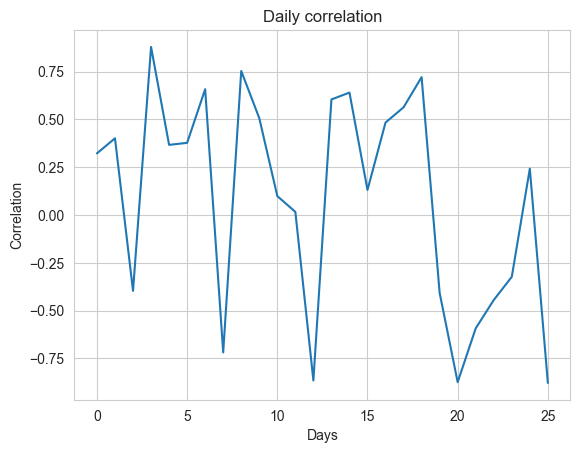

In [37]:
plt.plot(corr)
plt.title('Daily correlation')
plt.xlabel('Days')  
plt.ylabel('Correlation')  
plt.show()

In [38]:
def calculate_pnl(trades, prices,optimal_impact):
    cum_trades = trades.cumsum()
    gain = prices.iloc[-1]*cum_trades.iloc[-1] - prices * trades.shift(-1)
    impact_cost = -optimal_impact * trades.shift(-1)
    pnl = (gain + impact_cost).fillna(0).cumsum()
    notional = (trades.abs() * prices).sum()
    pnl =  pnl/notional
    return pnl


In [39]:
pnls = []
for item in l:
    temp = calculate_pnl(item[0],item[4],item[1])[-1]
    pnls.append(temp)
print(pnls)    

[105.52655996068692, 185.71521977779724, 127.67881866724888, -91.34447049606072, 54.650683200049286, 166.92744304637984, -13.695783879996869, 6.368462510984189, -115.53942814475646, 38.552801710214254, 1.804877021451182, -122.49539102370456, -140.47397748820237, 79.83813931741702, -19.972843967354123, 32.335288961692186, 48.172034940810704, 141.76681457816485, -21.36090931053092, 58.21212440225137, 47.3997376947596, -97.84271290762271, 41.65580331076766, 5.452519677498808, 156.32838105092938, -96.00474596352672]


C:\Users\zkr_l\AppData\Local\Temp\ipykernel_21256\2706453179.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = calculate_pnl(item[0],item[4],item[1])[-1]
C:\Users\zkr_l\AppData\Local\Temp\ipykernel_21256\2706453179.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  temp = calculate_pnl(item[0],item[4],item[1])[-1]
C:\Users\zkr_l\AppData\Local\Temp\ipykernel_21256\2706453179.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

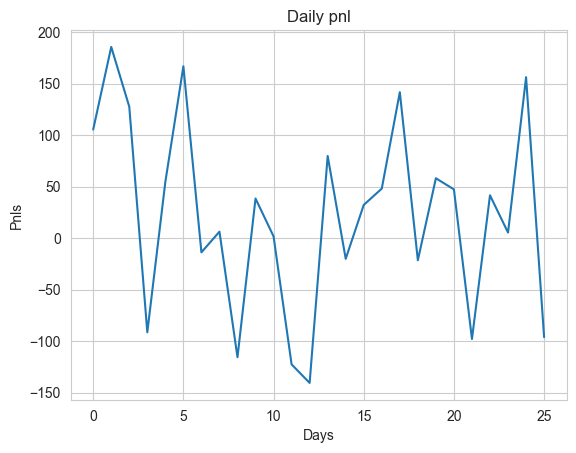

In [40]:
plt.plot(pnls)
plt.title('Daily pnl')
plt.xlabel('Days')  
plt.ylabel('Pnls')  
plt.show()

In [41]:
sharpe = []
for item in l:
    temp = calculate_pnl(item[0],item[4],item[1])
    temp = np.array(temp)
    index1 = np.nonzero(temp)
    temp = temp[index1]
    ret = (temp[1:]-temp[:-1])/temp[:-1]
    ret = np.array(ret)
    average_ret = np.nanmean(ret)
    excess_return = average_ret - 0.01/252
    stdd = np.nanstd(ret)
    
    sharpe_ratio = excess_return/stdd
    sharpe.append(sharpe_ratio)
print(sharpe)
    

[0.1404977715976547, 0.1406454334362641, 0.1398575496536767, 0.14215017674550146, 0.13888038340477155, 0.13896042639059628, 0.09523685828577466, 0.16265254326842316, 0.13625113322536694, 0.1369344191300644, 0.05901687323321804, 0.1375598970115327, 0.13957678398224796, 0.137036315112443, 0.15212046744384194, 0.1380698188412276, 0.13869837921174186, 0.1413927271173456, 0.13339188941632485, 0.13891663169793045, 0.1367008688272667, 0.13507073880412288, 0.13130054806395122, 0.15643327103317053, 0.13764558874518115, 0.13807884179442026]


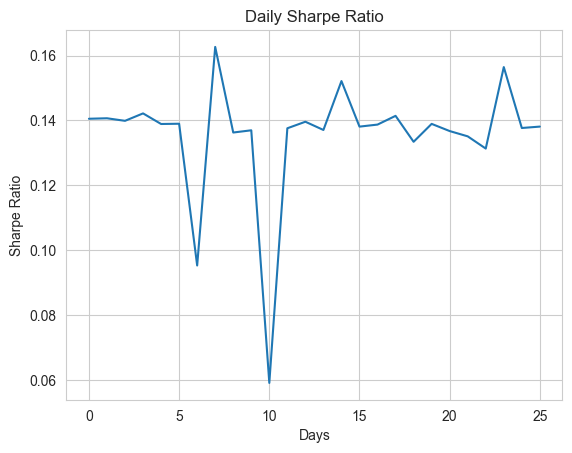

In [42]:
plt.plot(sharpe)
plt.title('Daily Sharpe Ratio')
plt.xlabel('Days') 
plt.ylabel('Sharpe Ratio') 
plt.show()

In [43]:
transaction_cost = []
for i in range(len(l)):
    temp = (l[i][4])*(l[i][0]).abs()*0.002+(0.5+0.05)*(l[i][0]).abs()
    transaction_cost.append(temp.mean())
print(transaction_cost)

[349.87127748645116, 368.47179211981376, 338.1423710629319, 442.29670491190916, 440.4705007643651, 555.1766815525463, 617.5394097775439, 670.6029536760915, 667.4443504718221, 549.8426543670104, 388.5751680232108, 439.1435765011028, 466.596052992918, 389.74117709431, 433.18820290949714, 372.1253471358312, 332.34350147123126, 714.447575475702, 494.78838101676024, 418.47590351899936, 394.0653577128425, 463.9979170583986, 316.618776914366, 468.50843396086094, 460.0930045806098, 365.27138862660144]


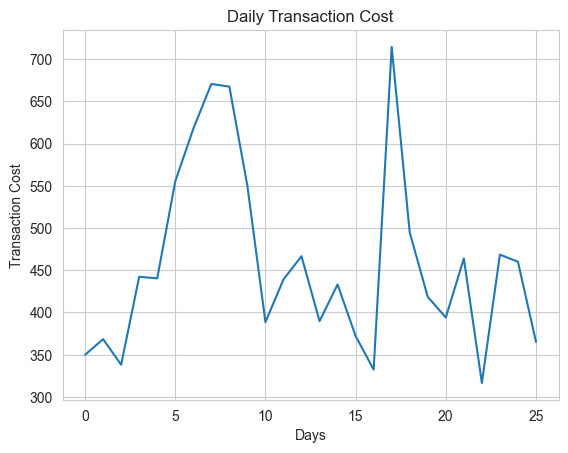

In [44]:
plt.plot(transaction_cost)
plt.title('Daily Transaction Cost')
plt.xlabel('Days')  # Label for the X-axis
plt.ylabel('Transaction Cost')  # Label for the Y-axis
plt.show()

In [45]:
mdd = []
for item in l:
    temp = calculate_pnl(item[0],item[4],item[1])
    temp = np.array(temp)
    peaks = np.maximum.accumulate(temp)
    dds = np.divide(temp - peaks, np.where(peaks == 0, 1, peaks))
    mdds = dds.min() 
    mdd.append(mdds)    
    
print(mdd)

[0.0, 0.0, 0.0, -91.34447049606072, 0.0, 0.0, -13.695783879996869, 0.0, -115.53942814475646, 0.0, -0.029638779431388457, -122.49539102370456, -140.47397748820237, 0.0, -19.9776970263811, -5.485813557781652e-05, 0.0, 0.0, -21.371729091893002, 0.0, -0.00011052595145663974, -97.84271290762271, 0.0, -0.0032787233414688557, 0.0, -96.00474596352672]


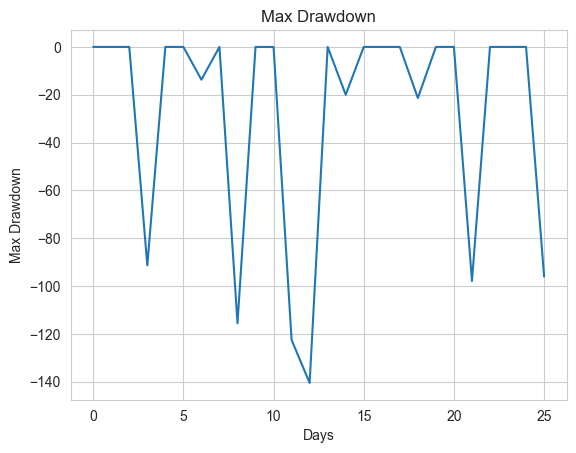

In [46]:
plt.plot(mdd)
plt.title('Max Drawdown')
plt.xlabel('Days')  # Label for the X-axis
plt.ylabel('Max Drawdown')  # Label for the Y-axis
plt.show()